In [1]:
import os
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib
matplotlib.rcParams["font.family"] = "arial"
import matplotlib.pyplot as plt
infos = pd.read_excel("../1_NanoNASCseq/results/nascent/summary.xlsx")

# Process metadata from seurat

In [2]:
dat1 = pd.read_csv("seurat_metadata.tsv", sep="\t", index_col=0)
dat2 = pd.read_csv("seurat_active_ident.tsv", sep="\t", index_col=0)
dat2.columns = ["CellType"]

In [3]:
dat = dat1.merge(dat2, left_index=True, right_index=True)

In [4]:
dat.to_csv("seurat_metadata.cell_type.tsv", sep="\t", index=False)

In [5]:
Counter(dat["CellType"])

Counter({'Morula-2': 68,
         'TE-1': 111,
         'Morula-1': 24,
         'ICM-1': 160,
         'TE-3': 182,
         'TE-2': 147,
         'PE': 146,
         'ICM-2': 212,
         'EPI-2': 98,
         'EPI-1': 118,
         'Unknown': 40})

In [6]:
cts = list(sorted(set(dat["CellType"])))
print(cts)

['EPI-1', 'EPI-2', 'ICM-1', 'ICM-2', 'Morula-1', 'Morula-2', 'PE', 'TE-1', 'TE-2', 'TE-3', 'Unknown']


In [7]:
cts = ['EPI-1', 'EPI-2', 'ICM-1', 'ICM-2', 'PE', 'TE-1', 'TE-2', 'TE-3']

In [8]:
data = dict()
for ct in cts:
    d = dat[[v.startswith(ct) for v in dat["CellType"]]]
    array1 = []
    array2 = []
    for run, cell in d[["Run", "Cell"]].values:
        path = "../1_NanoNASCseq/results/nascent/quantify/%s/%s.tsv" % (run, cell)
        df = pd.read_csv(path, sep="\t")
        df = df[df["Canonical"]]
        df = df[~df["GeneName"].duplicated()]
        df.index = df["GeneName"]
        s1 = df["Total"]
        s1.name = cell
        s2 = df["Nascent"]
        s2.name = cell
        array1.append(s1)
        array2.append(s2)
    s1 = pd.concat(array1, axis=1, sort=False).fillna(0).sum(axis=1)
    s1.name = "Total"
    s2 = pd.concat(array2, axis=1, sort=False).fillna(0).sum(axis=1)
    s2.name = "Nascent"
    df = pd.concat([s1, s2], axis=1)
    df["Ratio"] = df["Nascent"] / df["Total"]
    data[ct] = df

In [9]:
for ct, df in data.items():
    df["TPM"] = df["Total"] * 1e6 / df["Total"].sum()
    df["T"] = -3 / np.log2(1 - (df["Nascent"] / df["Total"]))
    df["Ksyn"] = df["TPM"] * np.log(2) / df["T"]

/home/chenzonggui/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until


/home/chenzonggui/miniconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:628: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale
/home/chenzonggui/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log2
  
/home/chenzonggui/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log2
  


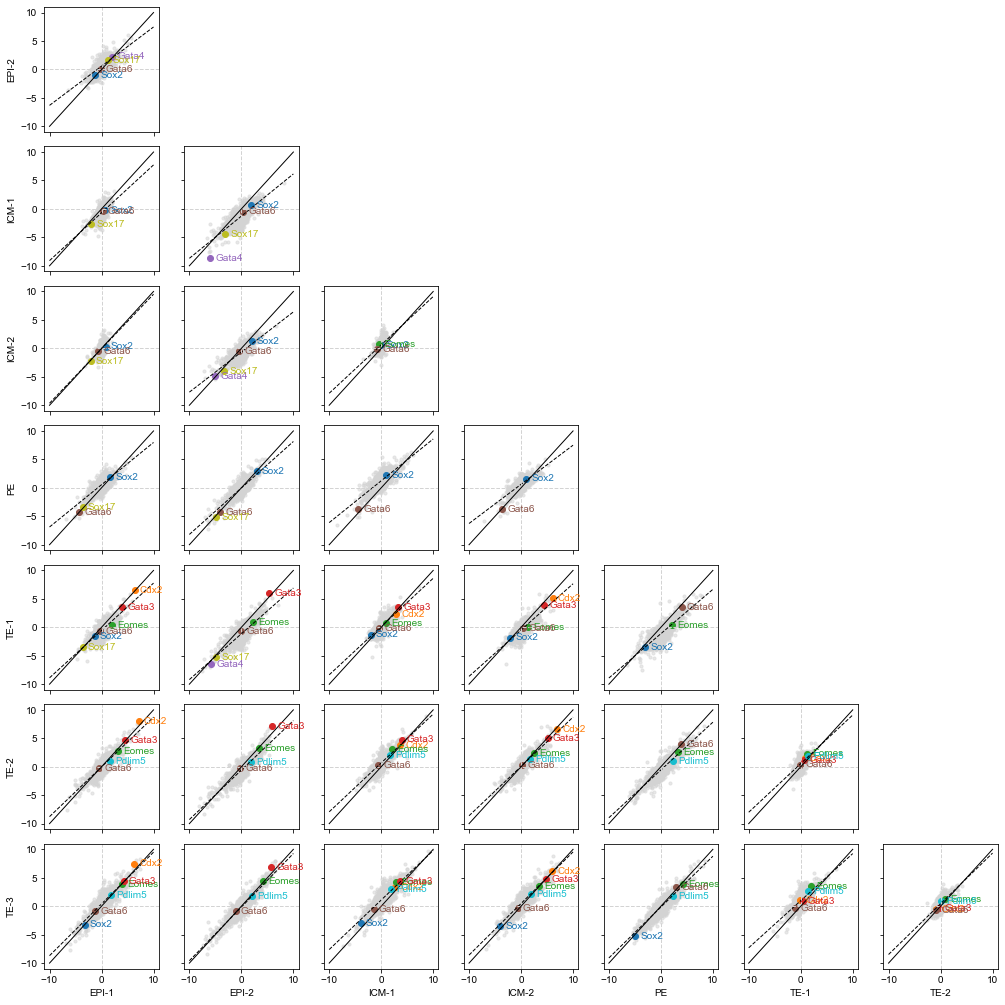

In [27]:
fig, axs = plt.subplots(len(cts), len(cts), figsize=(16, 16), sharex=True, sharey=True)
for i in range(len(cts)):
    for j in range(len(cts)):
        ax = axs[j][i]
        plt.sca(ax)
        
        ct1 = cts[i]
        ct2 = cts[j]
        df1 = data[ct1]
        df2 = data[ct2]
        df = df1.merge(df2, left_index=True, right_index=True, suffixes=["_1", "_2"])
        df["Mean_TPM"] = df[["TPM_1", "TPM_2"]].mean(axis=1)
        df["Log2FC_TPM"] = np.log2(df["TPM_2"] / df["TPM_1"])
        df["Log2FC_Ksyn"] = np.log2(df["Ksyn_2"] / df["Ksyn_1"])
        df = df[np.isfinite(df["Log2FC_TPM"])]
        df = df[np.isfinite(df["Log2FC_Ksyn"])]
        df = df[df["Mean_TPM"] > 50]

        xs = df["Log2FC_TPM"].values
        ys = df["Log2FC_Ksyn"].values
        a, b = 0, 0
        try:
            a, b = np.polyfit(xs, ys, 1)
        except Exception:
            pass

        plt.scatter(xs, ys, alpha=0.5, s=10, color="lightgrey")
        
        genes = ["Sox2", "Cdx2", "Eomes", "Gata3", "Gata4", "Gata6", "Gapdh", "Sox17", "Pdlim5"]
        colors = ["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C8", "C9"]
        for m, gname in enumerate(genes):
            try:
                row = df.loc[gname]
                x, y = row["Log2FC_TPM"], row["Log2FC_Ksyn"]
                plt.scatter([x], [y], color=colors[m], label=gname)
                plt.text(x + 1, y, gname, color=colors[m], va="center")
            except:
                pass

        xs1 = [-10, 10]
        ys1 = [a * x + b for x in xs1]
        # plt.plot(xs1, ys1, lw=1, color="black", ls="--")
        plt.axvline(0, lw=1, ls="--", color="lightgrey")
        plt.axhline(0, lw=1, ls="--", color="lightgrey")
        plt.plot([-10, 10], [-10, 10], ls="-", lw=1, color="black")
        # plt.legend()
        if i == 0:
            plt.ylabel(ct2)
        if j == len(cts) - 1:
            plt.xlabel(ct1)
            
        if i >= j:
            ax.set_visible(False)
        
plt.tight_layout()
plt.savefig("figures/blastocyst_dynamic_tmp_vs_synthesis.pdf", dpi=300)